In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from timeit import default_timer as timer

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
    StratifiedKFold,
)
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    FunctionTransformer,
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from sklearn.utils import check_random_state
import joblib
import optuna

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from skrub import GapEncoder, TableVectorizer
from scipy.spatial.distance import euclidean
from collections import Counter
from sklearn import datasets
from pathlib import Path

path = Path("mdsb-2023")

In [2]:
data = pd.read_parquet(path / "train.parquet")
ext = pd.read_csv(path / "external_data.csv")

In [3]:
# full = pd.read_csv(path / 'comptage-velo-donnees-compteurs.csv', sep=';').drop(columns=['Lien vers photo du site de comptage'])

# mmcom = pd.read_csv(path / 'comptage-multimodal-comptages.csv', sep=';')

# mmcom

# from scipy.spatial.distance import cdist
# from scipy.spatial import distance_matrix

# def find_closest_coordinates(lat1, lon1, lat2, lon2):
#     coordinates1 = list(zip(lat1, lon1))
#     coordinates2 = list(zip(lat2, lon2))

#     # Calculate pairwise distances
#     distances = distance_matrix(coordinates1, coordinates2)

#     # Find the index of the minimum distance for each point in df1
#     closest_indices = distances.argmin(axis=1)

#     return closest_indices

# def _merge_capacity(X):
#     X = X.copy()
#     stat = pd.read_csv(path / 'velib-emplacement-des-stations.csv', sep=';')

#     stat[['latitude', 'longitude']] = stat['Coordonnées géographiques'].str.split(r',\s+', expand=True)
#     stat[['latitude', 'longitude']] = stat[['latitude', 'longitude']].astype(np.float64)
#     stat.drop(columns=['Nom de la station', 'Coordonnées géographiques'], inplace=True)

#     counter = X.drop(columns=['date']).drop_duplicates()

#     closest_indices = find_closest_coordinates(counter['latitude'], counter['longitude'], stat['latitude'], stat['longitude'])
#     counter['ClosestIndex'] = closest_indices

#     # Merge based on the closest index
#     merged_df = pd.merge(counter, stat, left_on='ClosestIndex', right_index=True, how='inner')

#     # Drop the index column used for merging
#     merged_df = merged_df.drop(columns=['ClosestIndex', 'Identifiant station', 'latitude_y', 'longitude_y', 'latitude_x', 'longitude_x'])

#     X = X.merge(merged_df, on='counter_name', how='left')
#     X.rename(columns={'Capacité de la station':'Capacity'},inplace=True)
#     return X

# _merge_capacity(data).rename(columns={'Capacité de la station':'Capacity'},inplace=True)

# data[(data.date == "2021-07-23 11:00:00") & (data.site_name == "28 boulevard Diderot")]

# full_filt[(full_filt.date == "2021-07-23 11:00:00") & (full_filt.site_name == "28 boulevard Diderot")]

# EDA

In [4]:
data.sample(3)

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
450945,100050876-104050876,Totem 64 Rue de Rivoli O-E,100050876,Totem 64 Rue de Rivoli,743.0,2020-10-13 17:00:00,2019-09-04,"48.85735,2.35211",YTH19037970,48.85735,2.35211,6.612041
441162,100050876-103050876,Totem 64 Rue de Rivoli E-O,100050876,Totem 64 Rue de Rivoli,62.0,2020-10-15 21:00:00,2019-09-04,"48.85735,2.35211",YTH19037970,48.85735,2.35211,4.143135
874033,100060178-101060178,90 Rue De Sèvres SO-NE,100060178,90 Rue De Sèvres,38.0,2021-09-03 21:00:00,2020-07-22,"48.84638,2.31529",Y2H20052705,48.84638,2.31529,3.663562


In [5]:
ext.sample(3)

,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,td,u,...,hnuage1,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4
3116,7149,2020-09-05 06:00:00,102090,20,3,320,2.8,288.95,285.65,81,...,1000.0,3.0,6.0,1600.0,7.0,3.0,2500.0,NaN,NaN,NaN
2184,7149,2020-12-11 15:00:00,98900,-100,5,310,1.7,283.55,282.75,95,...,180.0,7.0,6.0,480.0,5.0,9.0,300.0,NaN,NaN,NaN
521,7149,2020-10-14 15:00:00,101520,-40,6,30,7.3,286.65,278.55,58,...,1200.0,3.0,NaN,1860.0,NaN,8.0,NaN,NaN,NaN,NaN


In [6]:
# Display the dimensions of the dataset
print(f"The dataset has {data.shape[0]} rows and {data.shape[1]} columns.")

# Display the column names in the dataset
print("\nColumns in the dataset:", data.columns.tolist())

# Display summary statistics for numerical columns
print("\nSummary statistics:")
display(data.describe())

# Display the total number of null values in the dataset
print(f"\nThe number of null values is:  {data.isnull().sum().sum()}.")

# Display unique values for each categorical column (excluding 'DateOfDeparture')
for c in data.select_dtypes(include=[object]).columns:
    n_unique_values = data[c].unique()
    print(f"\nUnique values in variable '{c}':\n{n_unique_values}")

# Display data types of each column in the dataset
print(f"\nThe types of the columns are the followings:\n{data.dtypes}")

# Display the count of numerical and categorical columns
print(
    f"\nThus we have {len(data.select_dtypes(include=np.number).columns)} numerical columns and {len(set(data.columns) - set(data.select_dtypes(include=np.number).columns))} non numerical columns."
)

The dataset has 496827 rows and 12 columns.

Columns in the dataset: ['counter_id', 'counter_name', 'site_id', 'site_name', 'bike_count', 'date', 'counter_installation_date', 'coordinates', 'counter_technical_id', 'latitude', 'longitude', 'log_bike_count']

Summary statistics:


,site_id,bike_count,latitude,longitude,log_bike_count
count,4.968270e+05,496827.000000,496827.000000,496827.000000,496827.000000
mean,1.053450e+08,60.191475,48.854343,2.345479,3.079917
std,3.210346e+07,87.590566,0.018554,0.038026,1.659899
min,1.000070e+08,0.000000,48.826360,2.265420,0.000000
25%,1.000475e+08,5.000000,48.840801,2.314440,1.791759
50%,1.000562e+08,29.000000,48.852090,2.353870,3.401197
75%,1.000563e+08,79.000000,48.864610,2.375870,4.382027
max,3.000147e+08,1302.000000,48.891720,2.409690,7.172425



The number of null values is:  0.

The types of the columns are the followings:
counter_id                         category
counter_name                       category
site_id                               int64
site_name                          category
bike_count                          float64
date                         datetime64[ns]
counter_installation_date    datetime64[ns]
coordinates                        category
counter_technical_id               category
latitude                            float64
longitude                           float64
log_bike_count                      float64
dtype: object

Thus we have 5 numerical columns and 7 non numerical columns.


In [13]:
# Display the dimensions of the extset
print(f"The extset has {ext.shape[0]} rows and {ext.shape[1]} columns.")

# Display the column names in the extset
print("\nColumns in the extset:", ext.columns.tolist())

# Display summary statistics for numerical columns
print("\nSummary statistics:")
display(ext.describe())

# Display the total number of null values in the extset
print(f"\nThe number of null values is:  {ext.isnull().sum().sum()}.")

# Display unique values for each categorical column (excluding 'DateOfDeparture')
for c in ext.select_dtypes(include=[object]).columns:
    n_unique_values = ext[c].unique()
    print(f"\nUnique values in variable '{c}':\n{n_unique_values}")

# Display ext types of each column in the extset
print(f"\nThe types of the columns are the followings:\n{ext.dtypes}")

# Display the count of numerical and categorical columns
print(
    f"\nThus we have {len(ext.select_dtypes(include=np.number).columns)} numerical columns"  # note that this considers only the dtype, there are actually more categorical cols
    f"and {len(set(ext.columns) - set(ext.select_dtypes(include=np.number).columns))} non numerical columns."
)

The extset has 3322 rows and 59 columns.

Columns in the extset: ['numer_sta', 'date', 'pmer', 'tend', 'cod_tend', 'dd', 'ff', 't', 'td', 'u', 'vv', 'ww', 'w1', 'w2', 'n', 'nbas', 'hbas', 'cl', 'cm', 'ch', 'pres', 'niv_bar', 'geop', 'tend24', 'tn12', 'tn24', 'tx12', 'tx24', 'tminsol', 'sw', 'tw', 'raf10', 'rafper', 'per', 'etat_sol', 'ht_neige', 'ssfrai', 'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'phenspe1', 'phenspe2', 'phenspe3', 'phenspe4', 'nnuage1', 'ctype1', 'hnuage1', 'nnuage2', 'ctype2', 'hnuage2', 'nnuage3', 'ctype3', 'hnuage3', 'nnuage4', 'ctype4', 'hnuage4']

Summary statistics:


,numer_sta,pmer,tend,cod_tend,dd,ff,t,td,u,vv,...,hnuage1,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4
count,3322.0,3322.000000,3322.000000,3322.000000,3322.000000,3322.000000,3322.000000,3322.000000,3322.000000,3322.000000,...,2867.000000,1695.000000,1443.000000,1695.000000,618.000000,470.000000,618.000000,42.000000,87.000000,42.000000
mean,7149.0,101682.886815,-0.237809,4.273028,184.379892,3.654154,285.877905,281.006442,74.775135,20142.338952,...,2028.674573,5.030678,4.515593,2692.943953,5.441748,3.961702,3310.695793,3.476190,6.735632,3205.000000
std,0.0,923.888170,122.191314,2.713199,103.708084,2.000353,6.851700,5.634409,17.022427,10283.556918,...,2377.241533,2.003304,2.463098,2309.340104,2.017108,3.042454,2423.703985,2.360633,3.196873,2595.553656
min,7149.0,97260.000000,-750.000000,0.000000,0.000000,0.000000,267.650000,260.750000,24.000000,120.000000,...,0.000000,1.000000,0.000000,60.000000,1.000000,0.000000,300.000000,1.000000,0.000000,360.000000
25%,7149.0,101200.000000,-70.000000,2.000000,80.000000,2.200000,280.950000,276.950000,63.000000,12710.000000,...,500.000000,3.000000,3.000000,1080.000000,4.250000,0.000000,1400.000000,1.000000,6.000000,1112.500000
50%,7149.0,101820.000000,0.000000,3.000000,200.000000,3.400000,285.850000,281.450000,79.000000,20000.000000,...,1080.000000,5.000000,6.000000,1800.000000,6.000000,3.000000,2430.000000,2.500000,8.000000,2150.000000
75%,7149.0,102287.500000,70.000000,7.000000,260.000000,4.900000,290.650000,285.550000,89.000000,25000.000000,...,2100.000000,7.000000,6.000000,3400.000000,7.000000,6.000000,5000.000000,5.750000,9.000000,5800.000000
max,7149.0,103920.000000,720.000000,8.000000,360.000000,14.600000,307.450000,293.150000,100.000000,60000.000000,...,9000.000000,8.000000,9.000000,9000.000000,8.000000,9.000000,9000.000000,7.000000,9.000000,8000.000000



The number of null values is:  71572.

Unique values in variable 'date':
['2021-01-01 00:00:00' '2021-01-01 03:00:00' '2021-01-01 06:00:00' ...
 '2020-09-30 15:00:00' '2020-09-30 18:00:00' '2020-09-30 21:00:00']

The types of the columns are the followings:
numer_sta      int64
date          object
pmer           int64
tend           int64
cod_tend       int64
dd             int64
ff           float64
t            float64
td           float64
u              int64
vv             int64
ww             int64
w1           float64
w2           float64
n            float64
nbas         float64
hbas         float64
cl           float64
cm           float64
ch           float64
pres           int64
niv_bar      float64
geop         float64
tend24       float64
tn12         float64
tn24         float64
tx12         float64
tx24         float64
tminsol      float64
sw           float64
tw           float64
raf10        float64
rafper       float64
per            int64
etat_sol     float64
ht_nei

In [36]:
data.counter_name.nunique(), data.site_name.nunique()

(56, 30)

# Visual

<Axes: xlabel='date'>

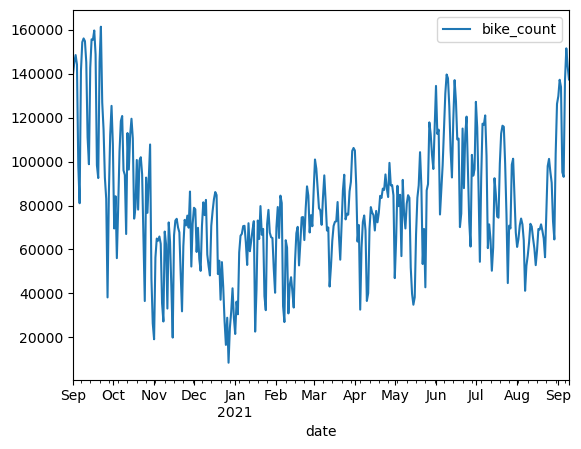

In [24]:
mask = (data["date"] > pd.to_datetime("2020/12/20")) & (
    data["date"] < pd.to_datetime("2020/12/29")
)

data[:].groupby(pd.Grouper(freq="1d", key="date"))[["bike_count"]].sum().plot()

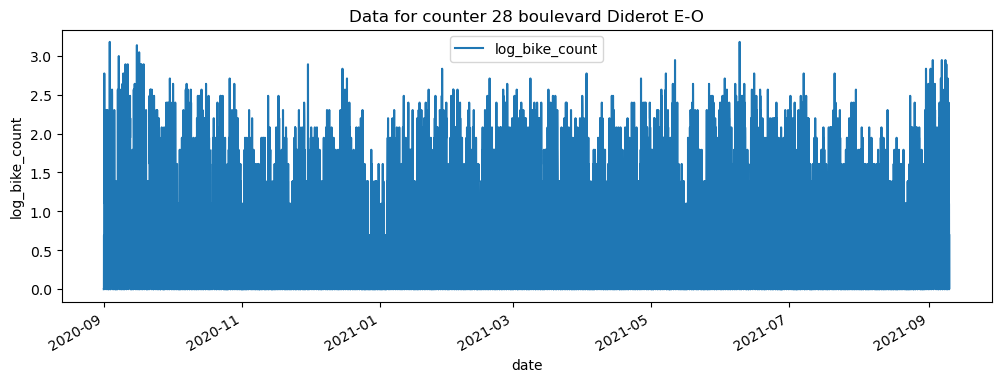

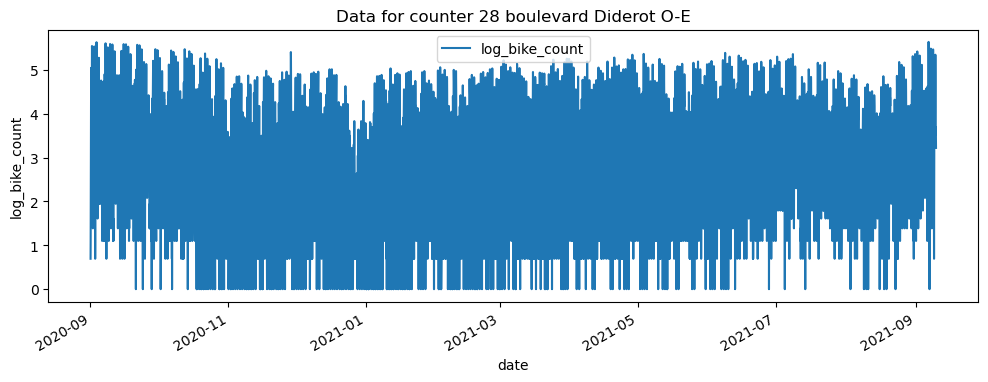

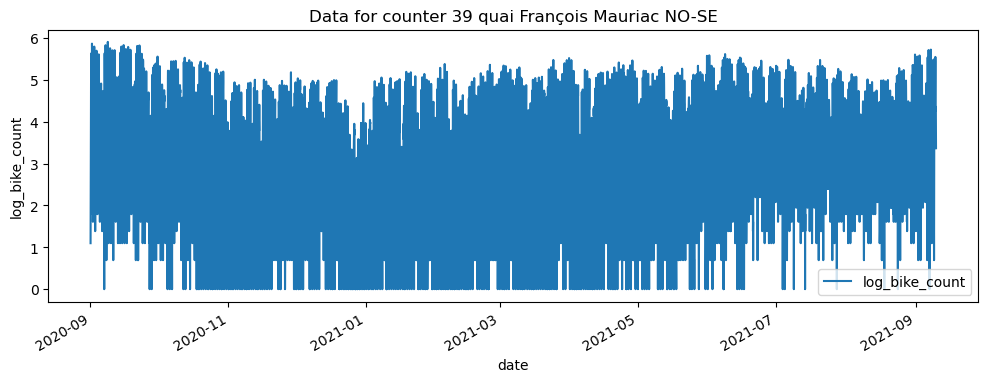

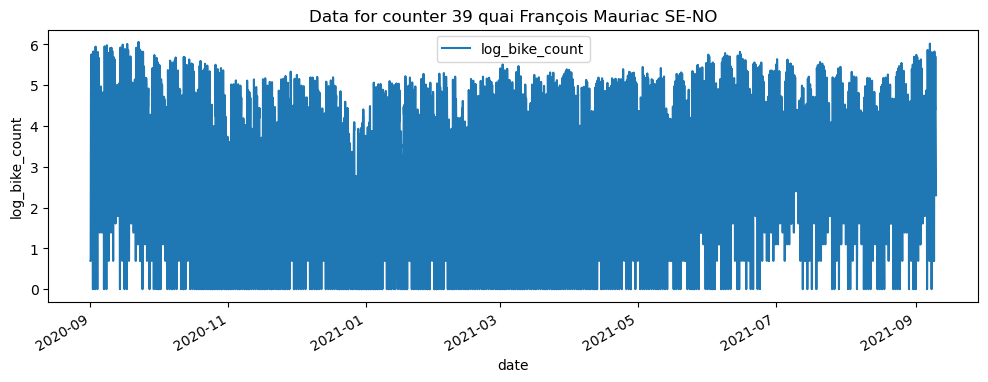

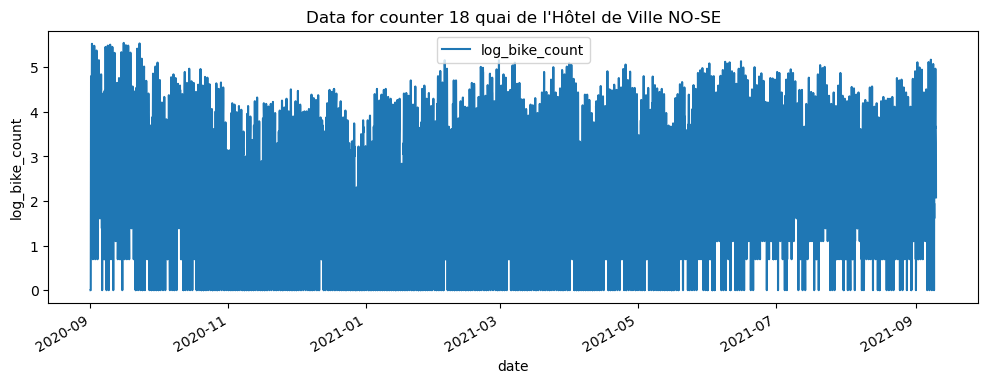

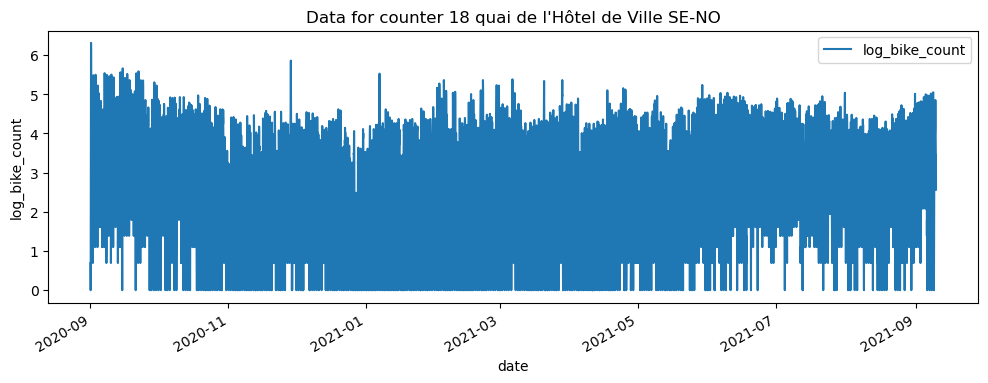

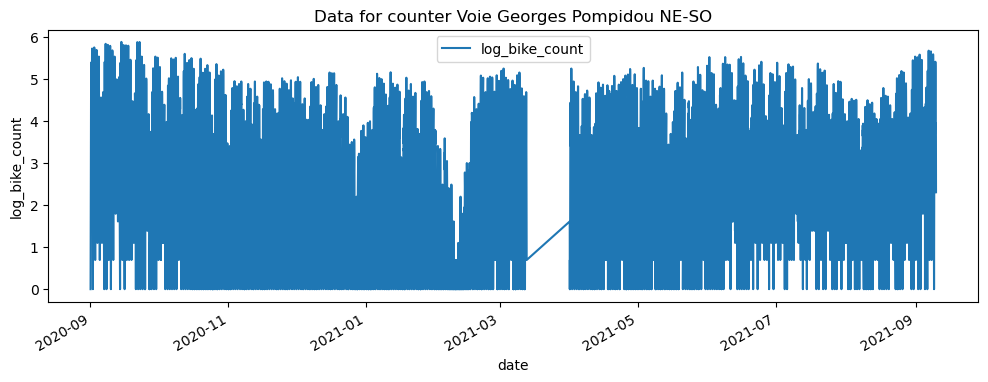

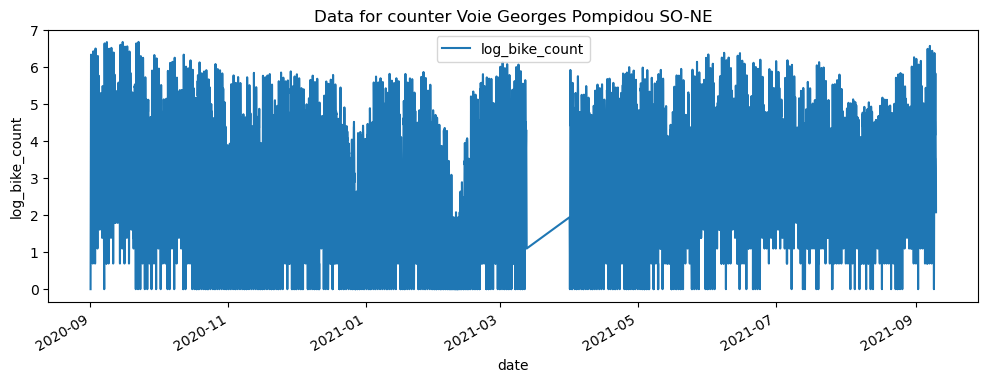

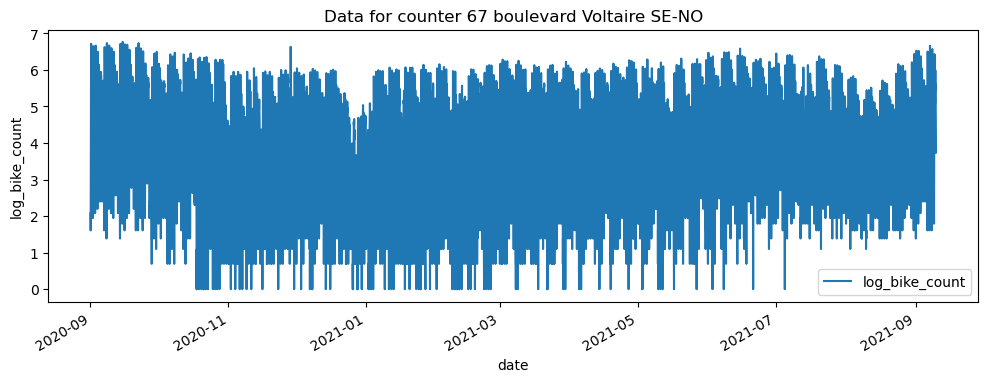

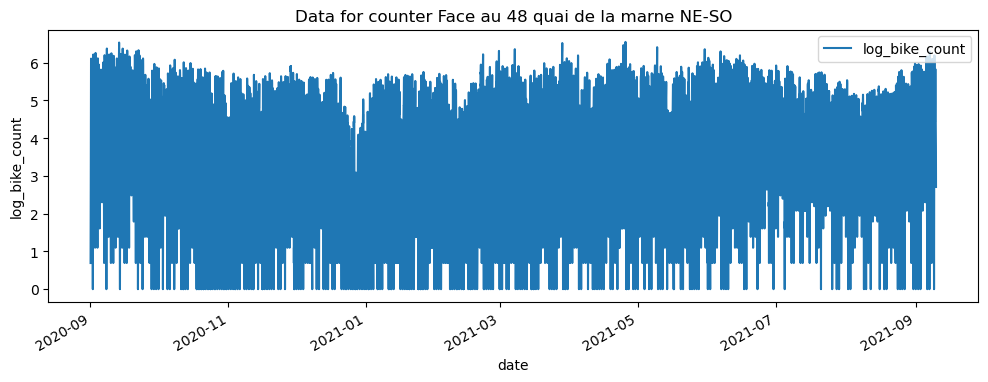

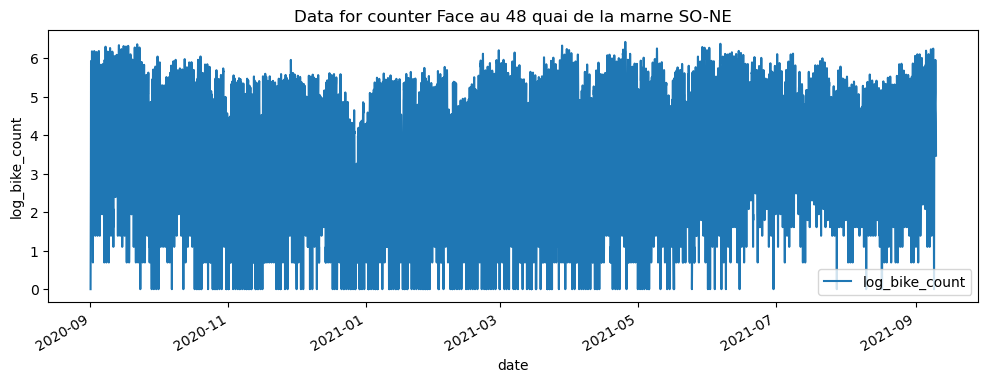

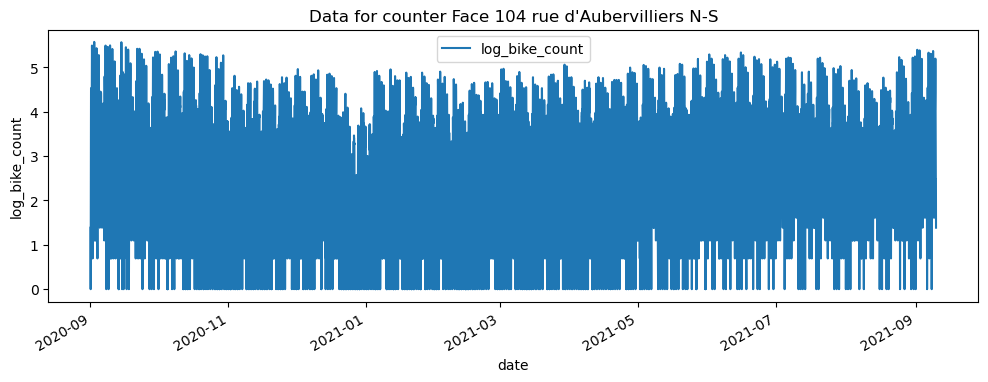

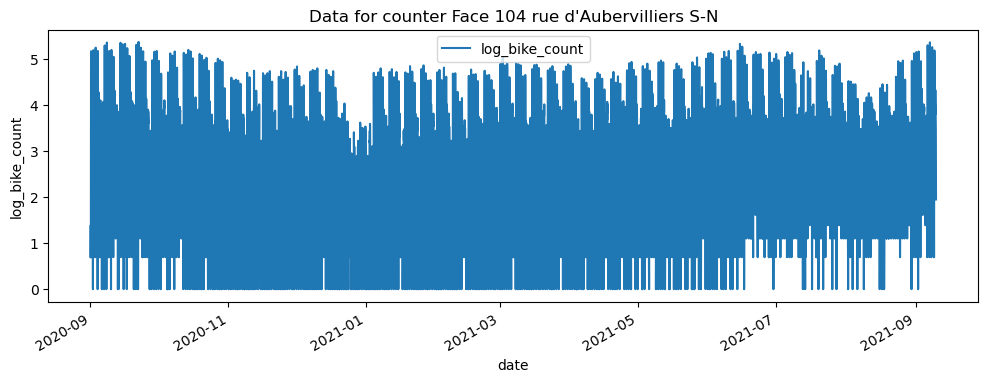

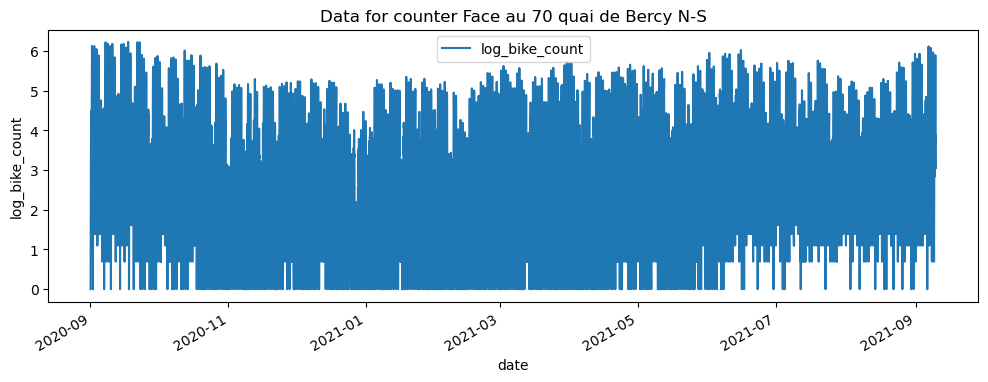

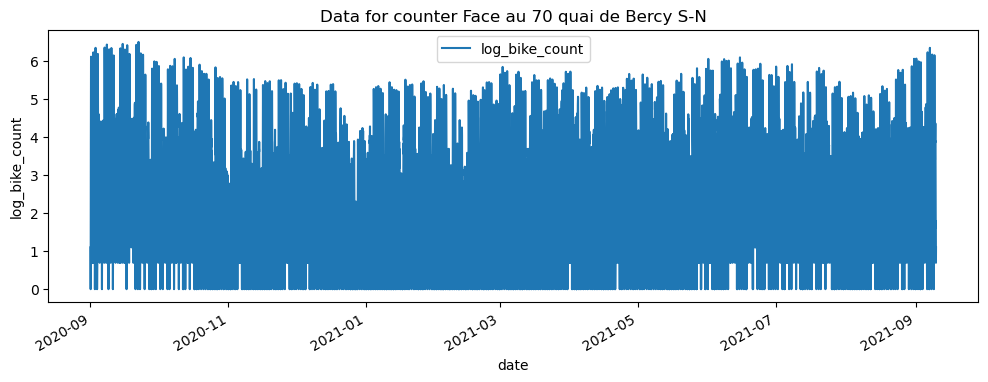

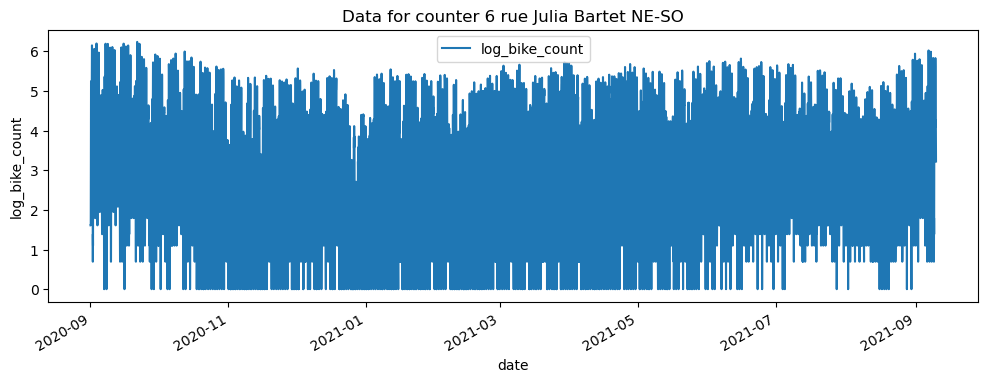

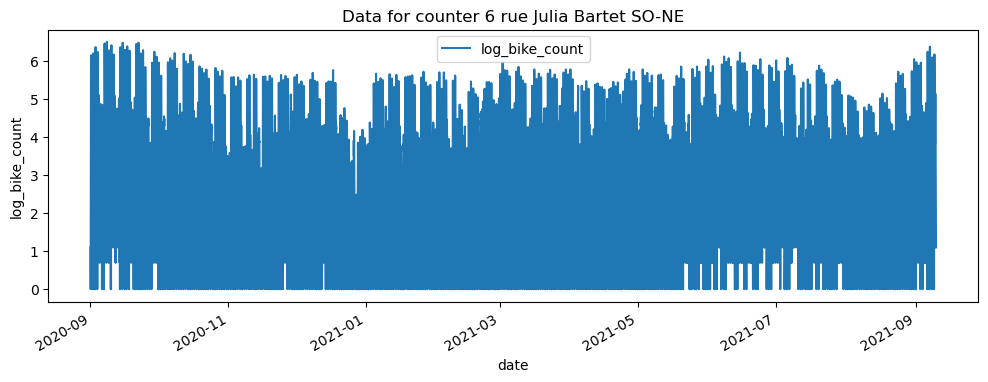

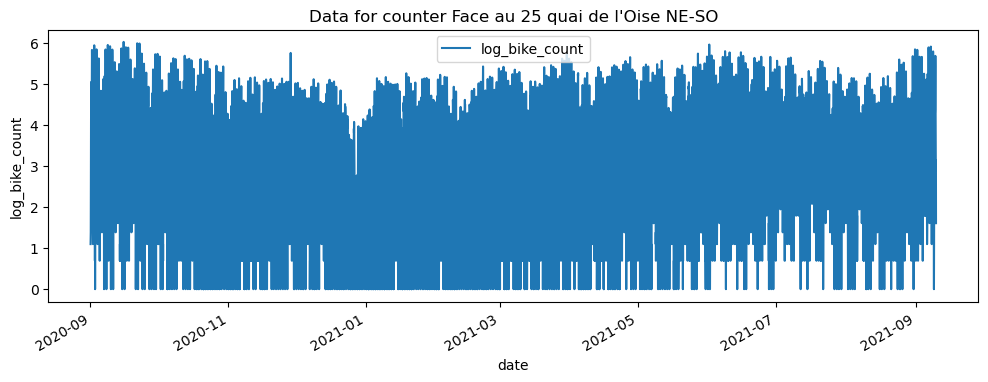

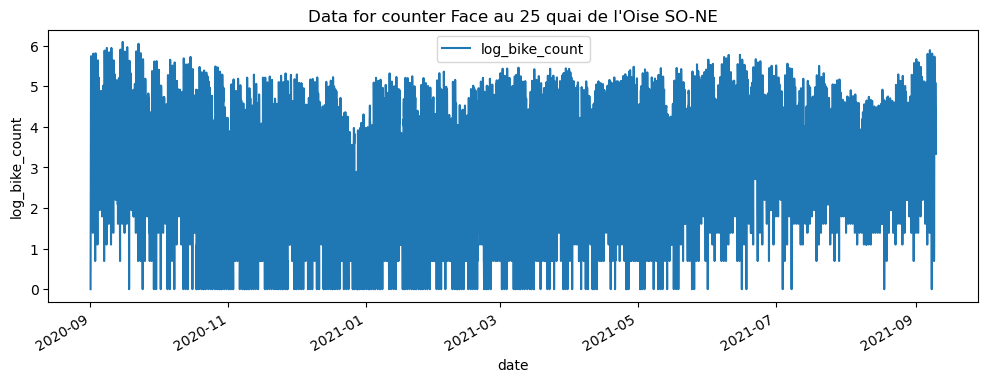

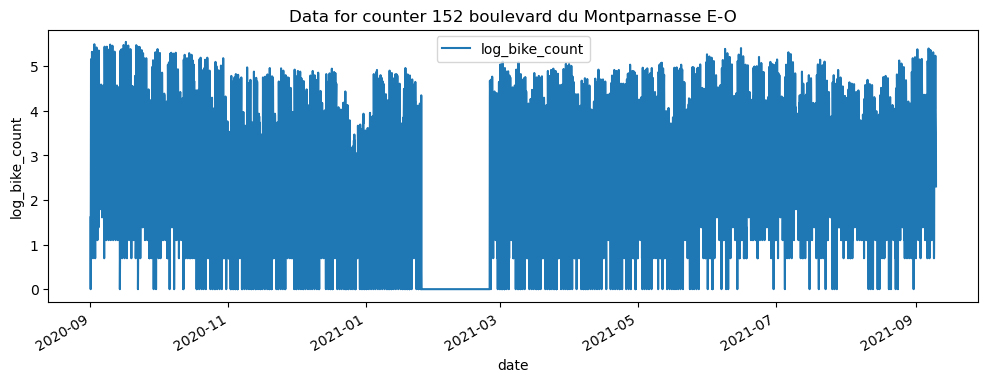

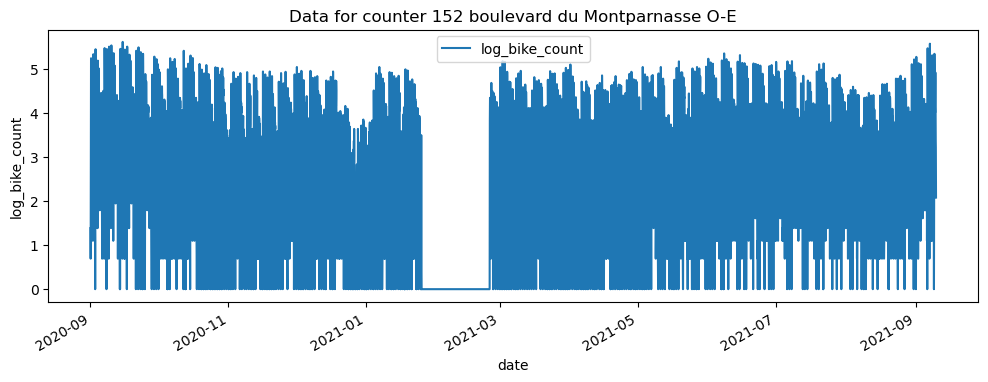

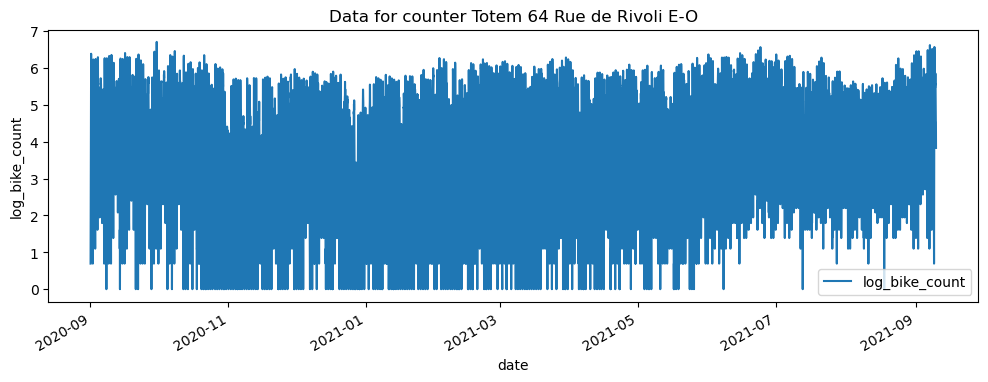

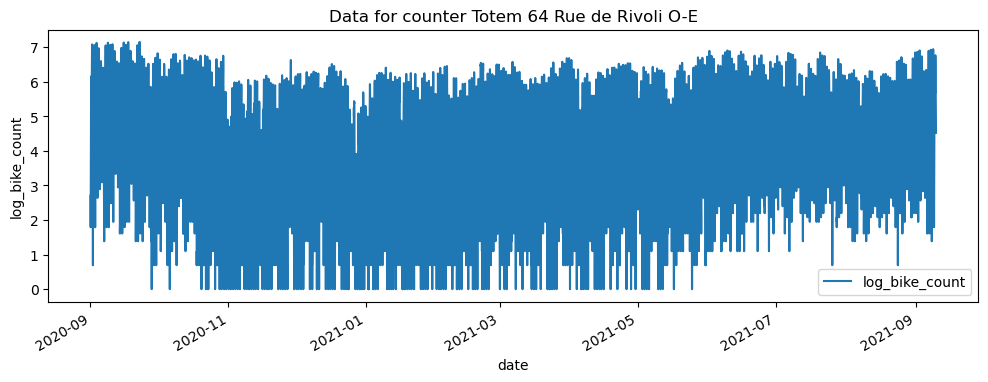

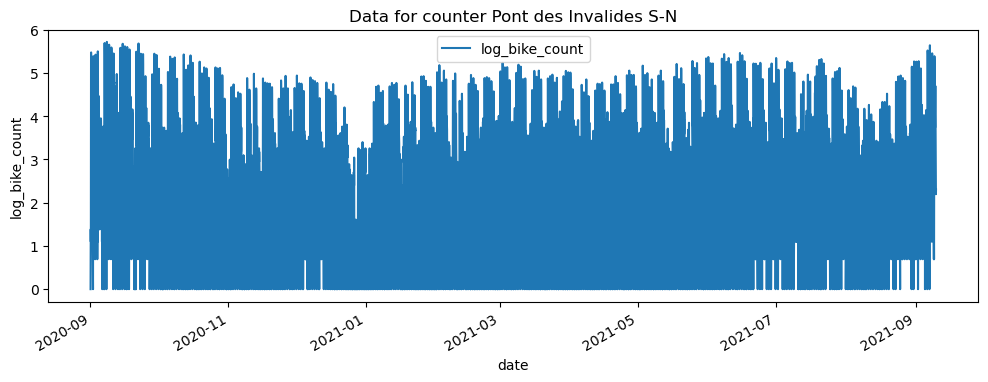

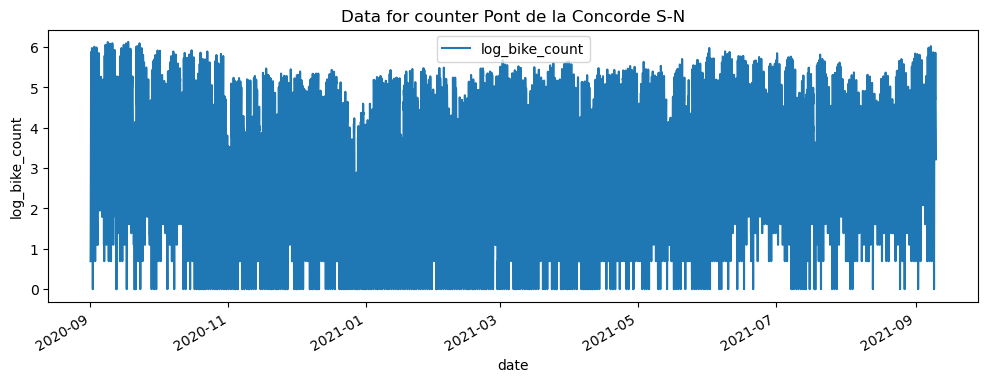

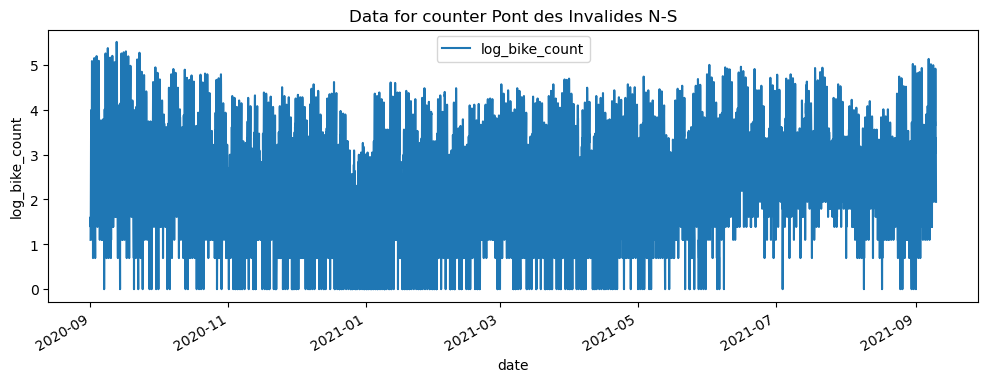

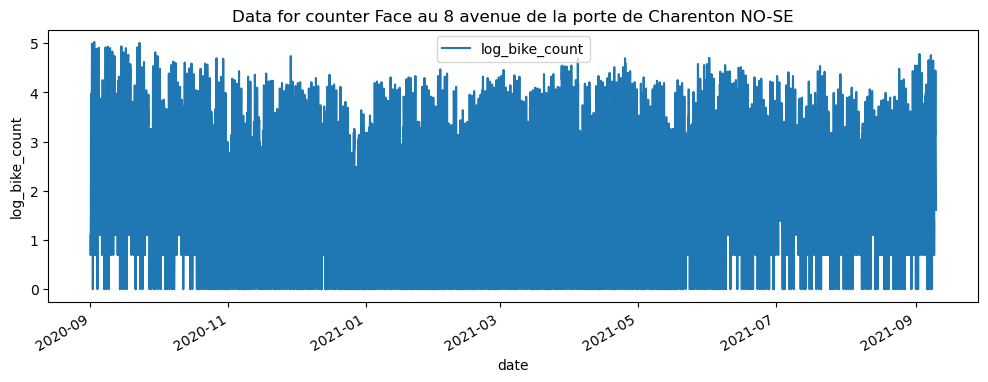

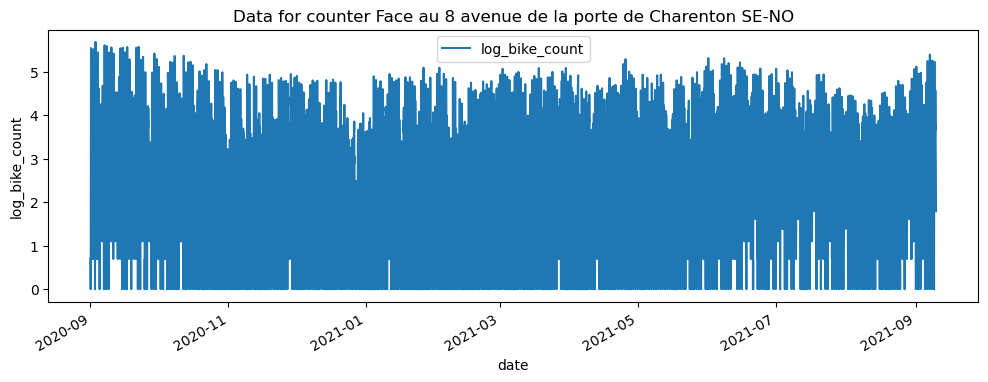

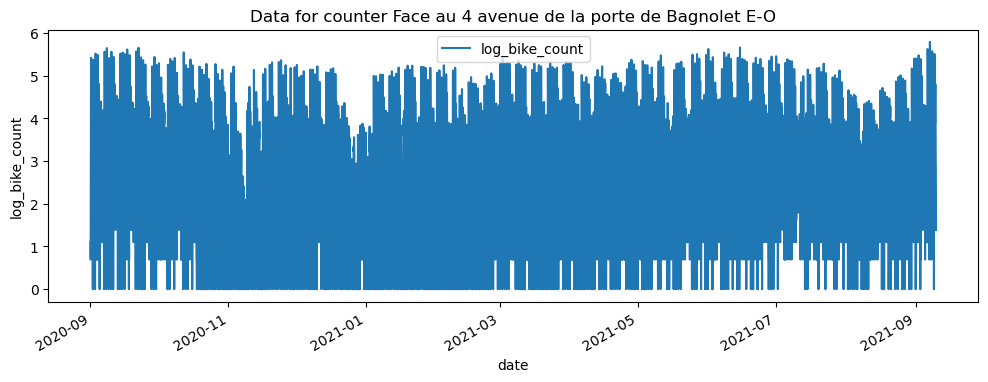

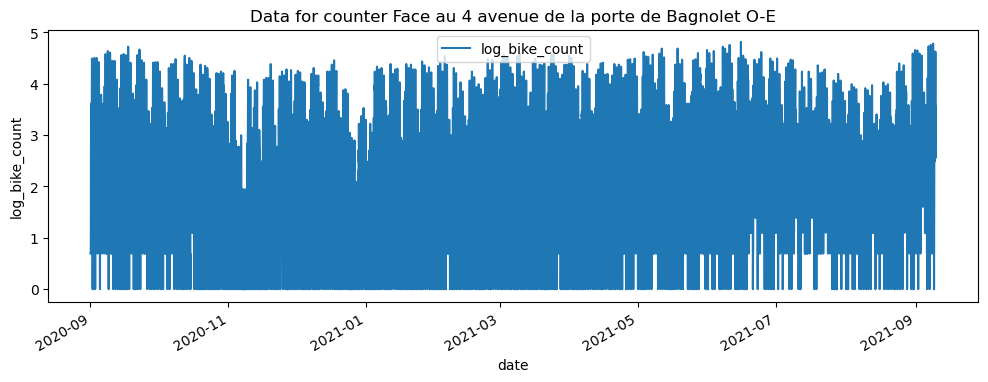

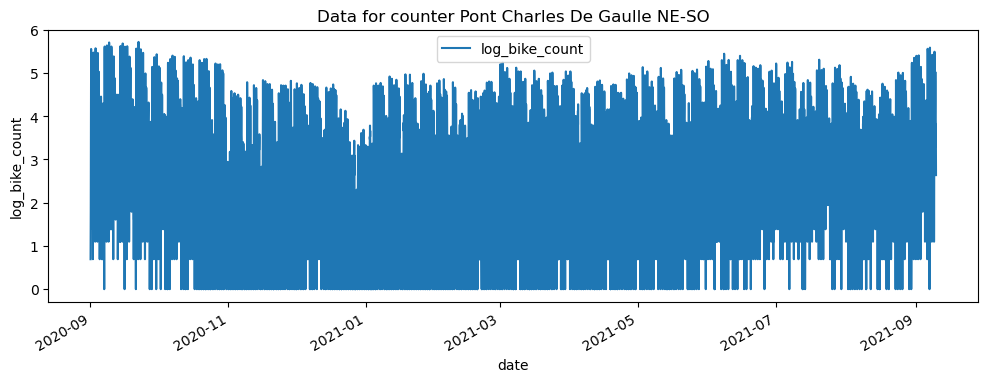

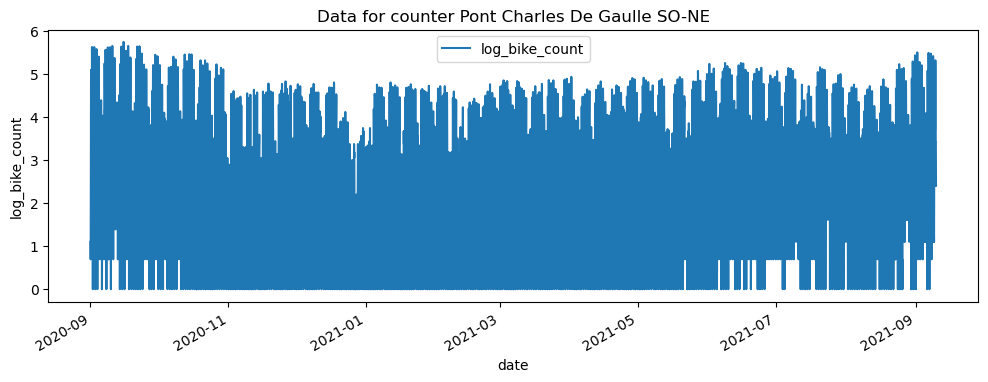

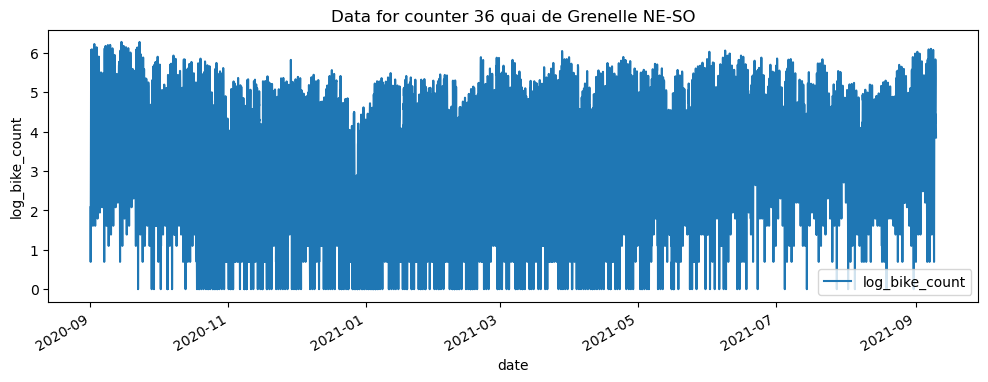

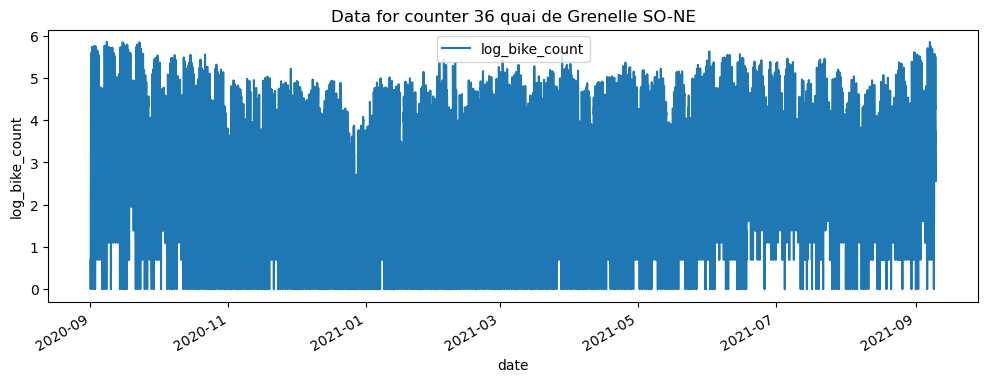

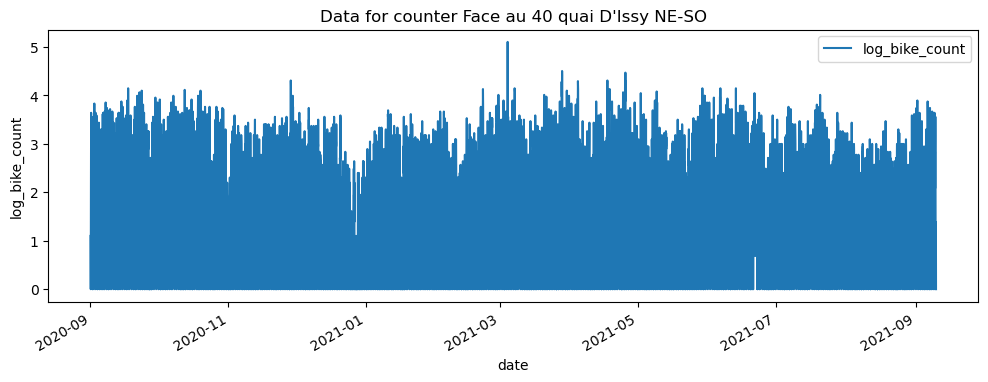

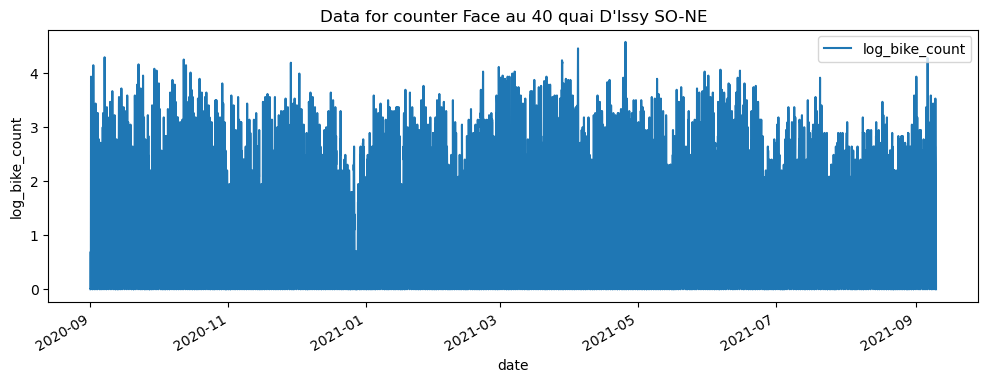

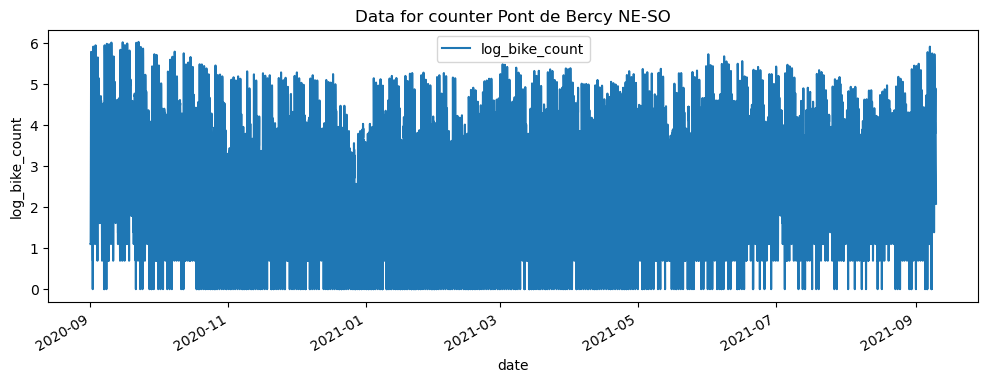

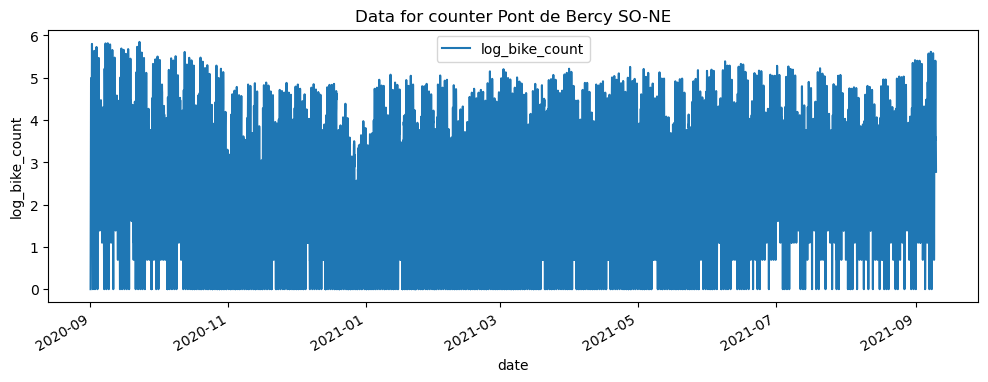

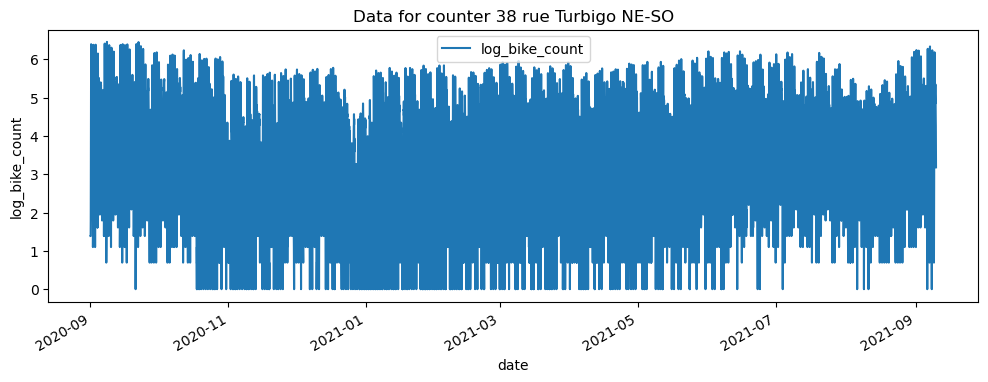

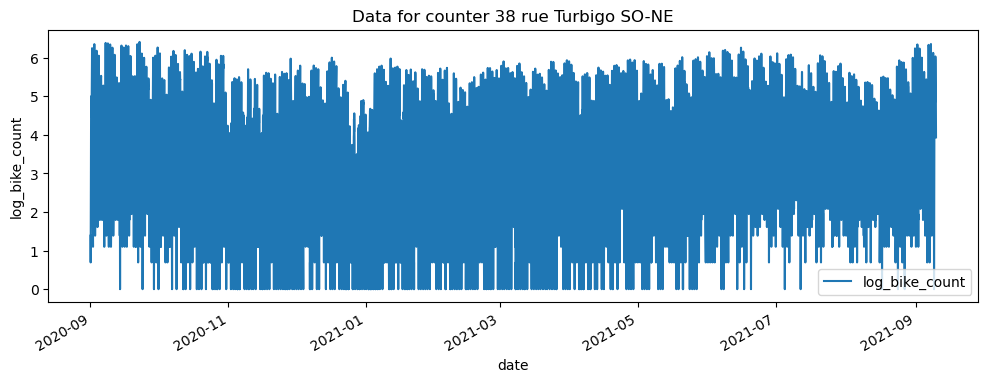

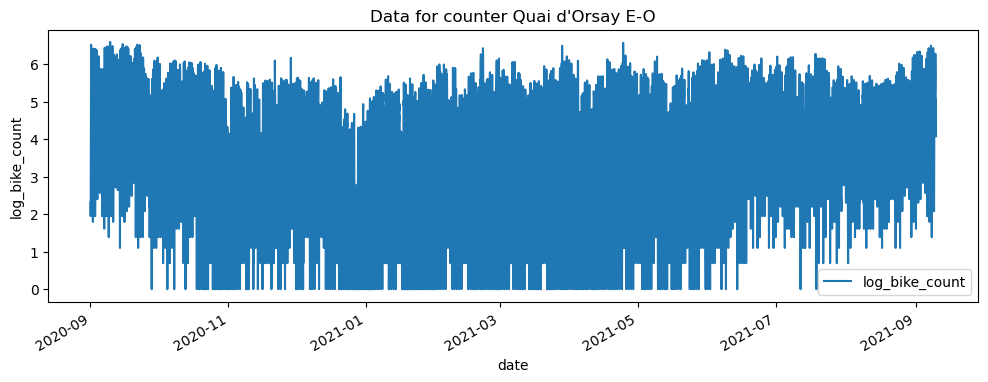

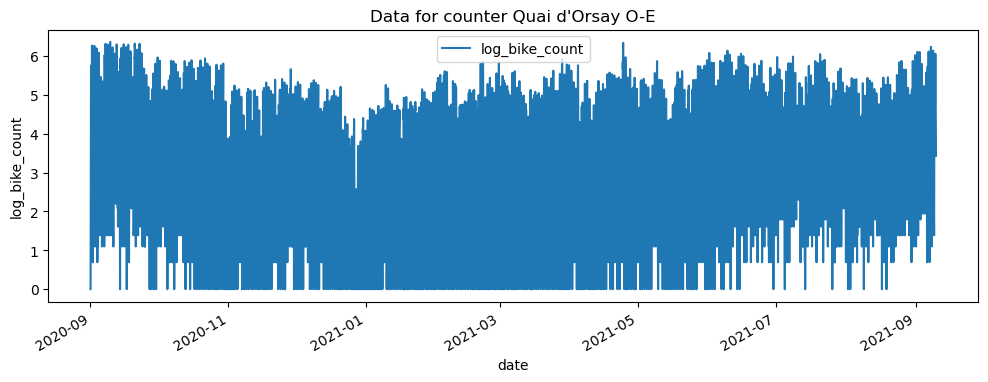

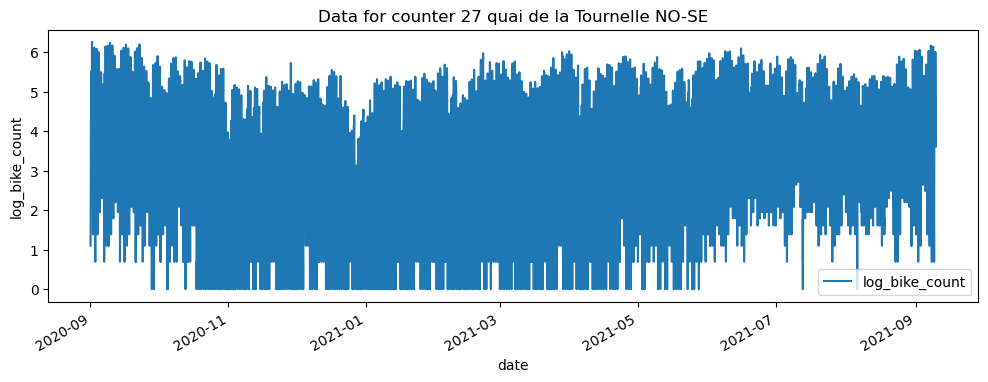

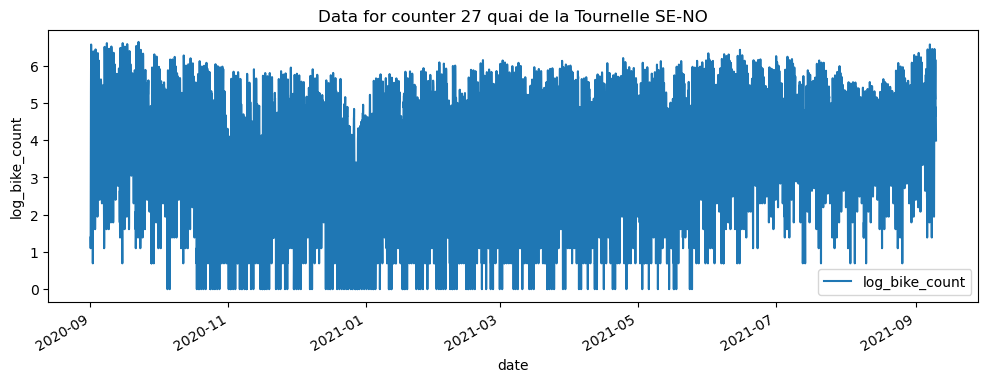

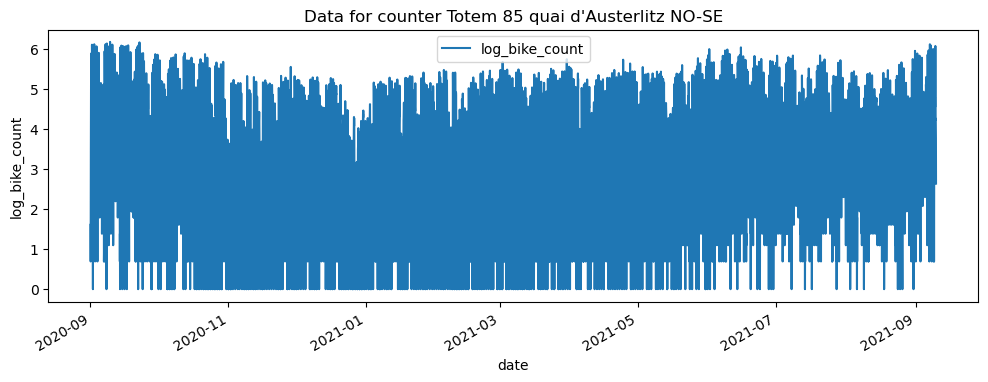

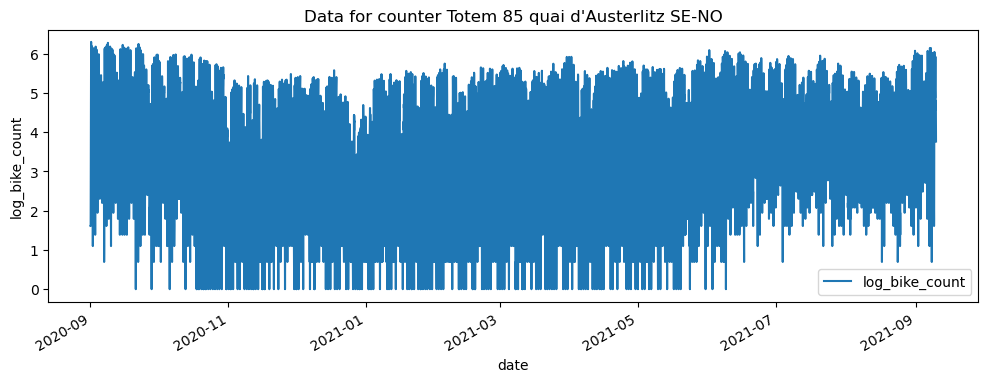

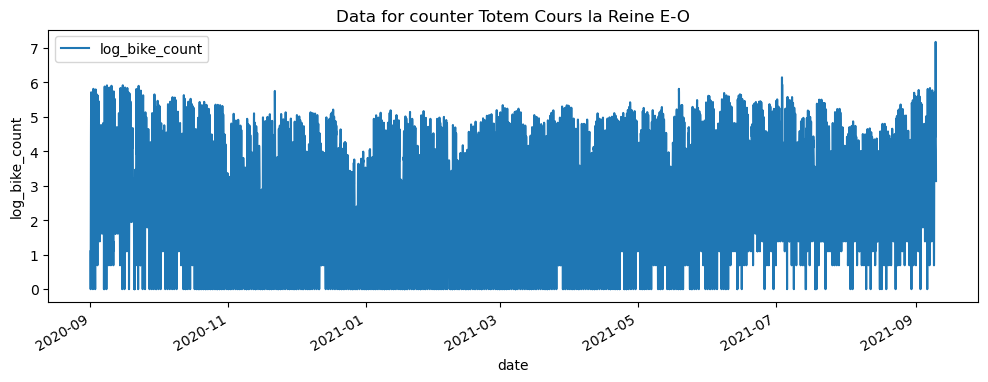

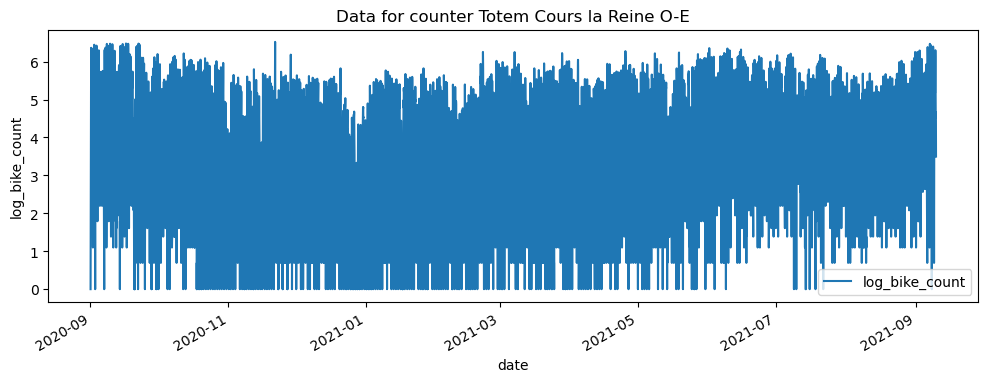

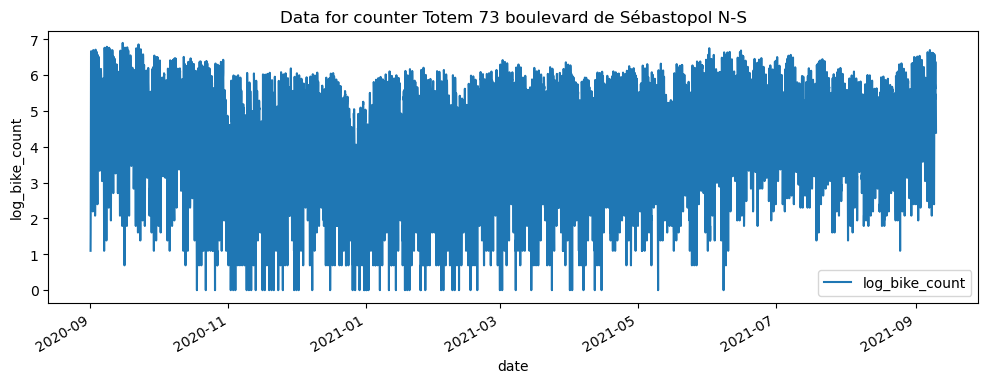

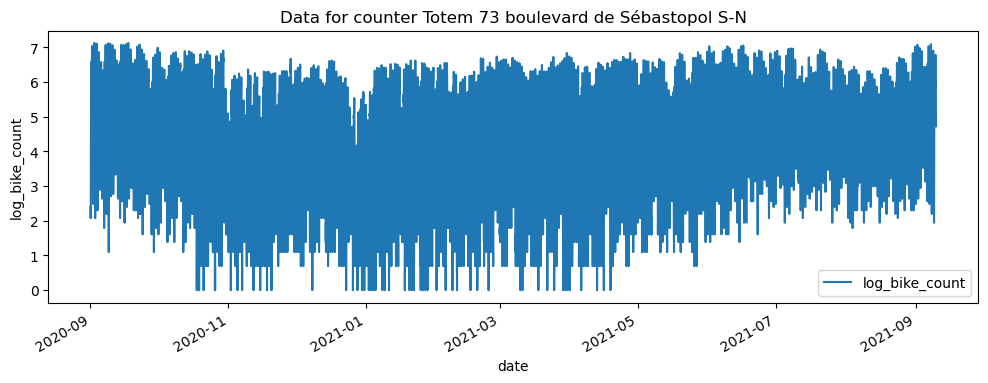

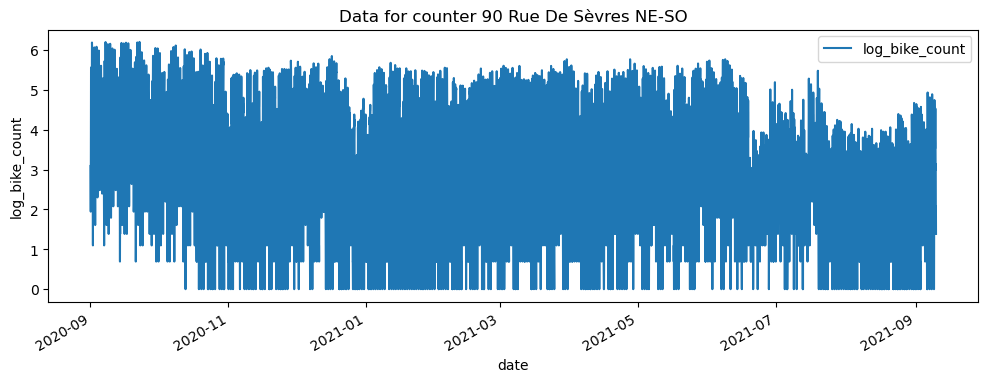

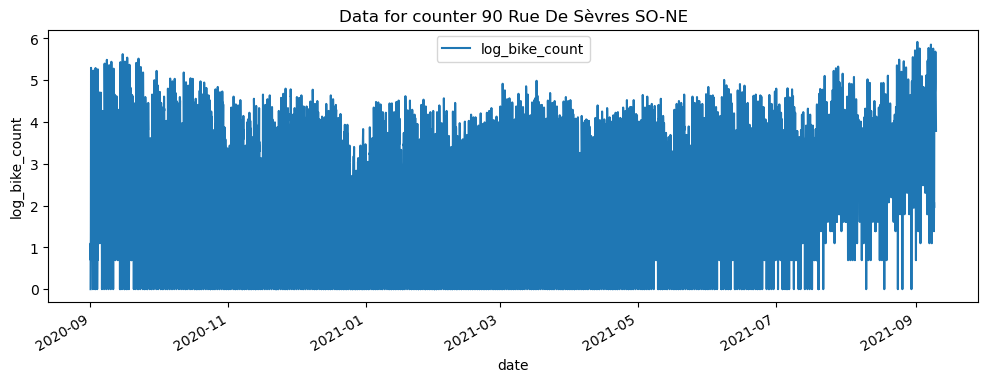

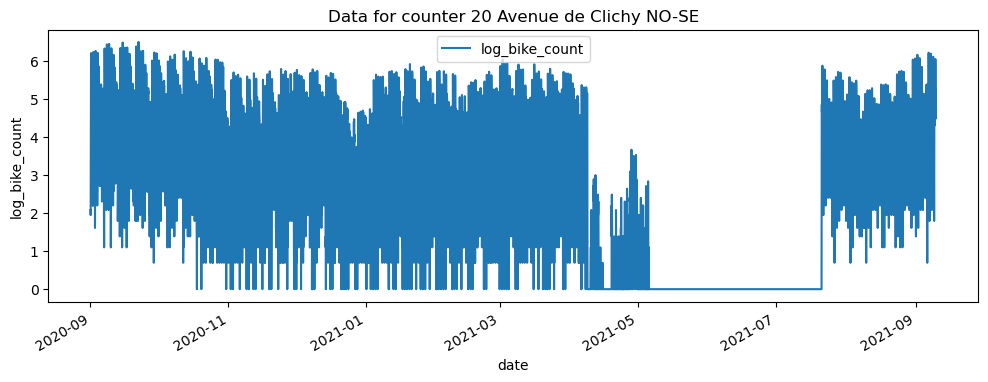

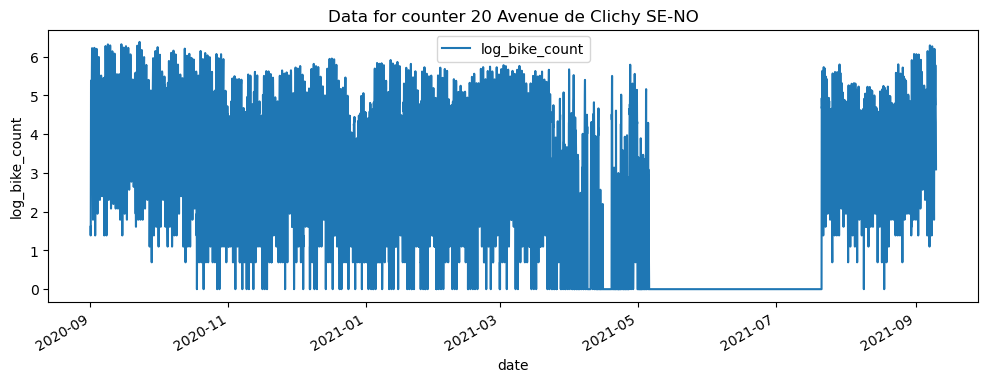

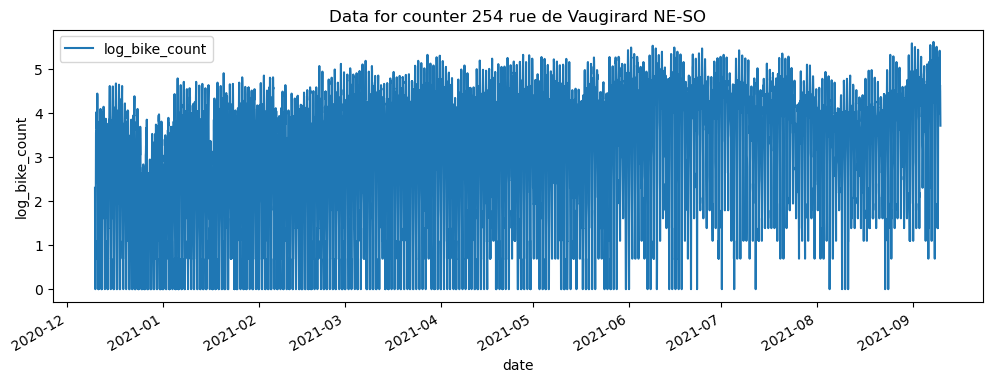

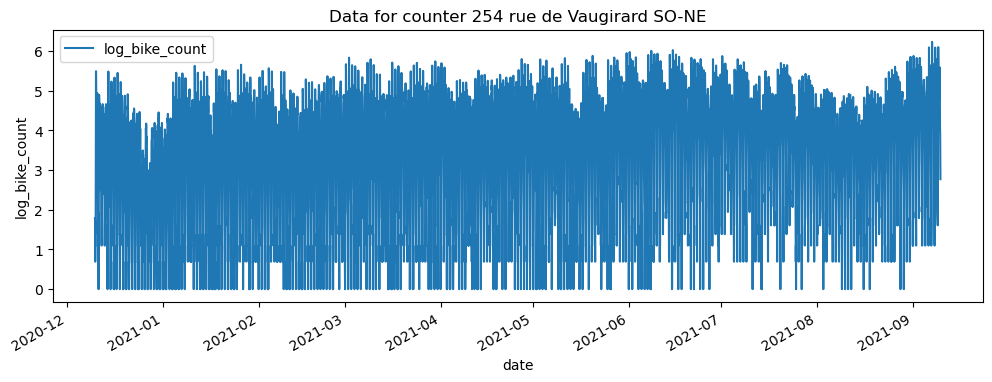

In [9]:
X, y = data, data["bike_count"]
for n in X["counter_name"].unique():
    mask = (
        X["counter_name"]
        == n
        #         & (X["date"] > pd.to_datetime("2019/09/01"))
        #         & (X["date"] < pd.to_datetime("2021/09/08"))
    )

    fig, ax = plt.subplots(figsize=(12, 4))

    data.loc[mask].plot(x="date", y="log_bike_count", ax=ax)
    ax.set_title(f"Data for counter {n}")
    ax.set_ylabel("log_bike_count")
    plt.show()